# Source position continuous optimisation based on FWI results (test case B and D)

In [1]:
import os

###############################################################################
# Decide on CPU or GPU here
use_gpu = False  # Set to False if you want CPU only
###############################################################################

if use_gpu:
    # Prevent JAX from preallocating most of the GPU memory
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
    # Force JAX to use GPU
    import jax
    jax.config.update("jax_platform_name", "gpu")
else:
    # Force JAX to use CPU
    import jax
    jax.config.update("jax_platform_name", "cpu")

In [2]:
import numpy as np
from jax import jit, vjp, vmap, value_and_grad, random
import jax
from jax import numpy as jnp
from jax import lax
from jaxdf.operators import compose
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display, clear_output

from cmcrameri import cm

import optax
import equinox as eqx
from jax.example_libraries import optimizers
import time


from jwave.geometry import Domain, Medium
from jwave.signal_processing import smooth

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field, generate_2D_gridded_src_rec_positions, ricker_wavelet, acoustic2D, acoustic2D_pml, acoustic2D_pml_minmem, acoustic2D_cpml_minmem, acoustic2D_cpml_minmem_strips_diff, acoustic2D_pml_4th_minmem, generate_src_rec_positions

from hybridoed.oed import *


(500, 1, 70, 70)


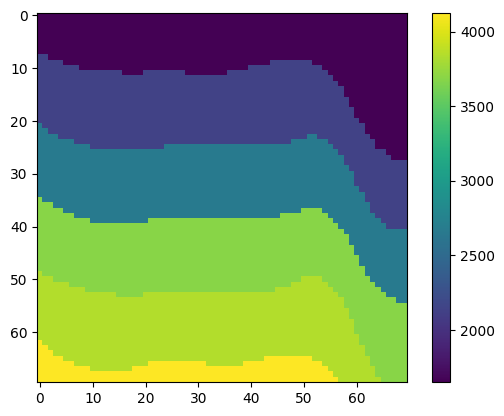

<class 'jaxlib.xla_extension.ArrayImpl'>


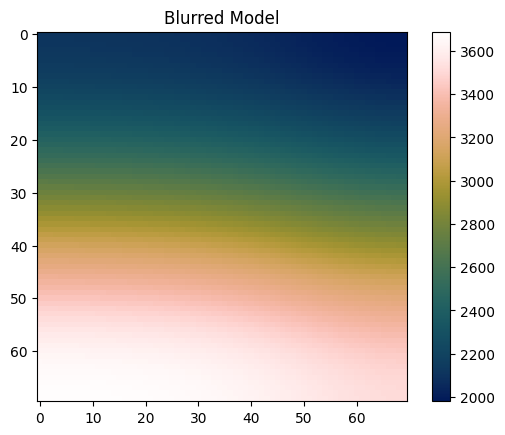

(70, 70)


In [3]:
# Load model

model = jnp.load('model1.npy')

print(model.shape)

model_index = 84

true_model = model[model_index,0,:,:]
# true_model = model
plt.imshow(true_model)
plt.colorbar()
plt.show()
print(type(true_model))

from scipy.ndimage import gaussian_filter

# Apply a Gaussian blur
# Adjust sigma as needed; larger sigma = more blur
blurred_model = gaussian_filter(true_model, sigma=20)

# Visualize the blurred model
plt.figure()
plt.imshow(blurred_model, cmap=cm.batlowW)
plt.colorbar()
plt.title('Blurred Model')
plt.show()
print(blurred_model.shape)

# homogenous model of the velocity avegare

homogenous_model = jnp.ones(true_model.shape) * jnp.mean(true_model)

# plt.imshow(homogenous_model)

In [4]:

# SELECT THE PROPER VARIABLE TO OPTMISE (SRC OR REC). THE ORIGINAL IS OPTIMISE FOR SOURCE (src_coords_list, receiver_coords_list)
# receiver_coords_list, src_coords_list = generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=5, num_receivers=5)
src_coords_list, receiver_coords_list = generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=5, num_receivers=5)

# Define your exact desired grid lines:
# src_x = [10.0, 30.0, 50.0]
# src_y = [10.0, 30.0, 50.0]

# rec_x = [5.0, 25.0, 45.0, 65.0]
# rec_y = [5.0, 25.0, 45.0, 65.0]  

# src_coords_list, receiver_coords_list = generate_src_rec_positions(src_x, src_y, rec_x, rec_y)



# num_sources = src_coords_list.shape[0]
sensors_positions = (receiver_coords_list[:,0],receiver_coords_list[:,1])
# sensors = Sensors(positions=sensors_positions)
source_positions = (src_coords_list[:,0],src_coords_list[:,1])

# mask the sensors positions in the domain
# mask = jnp.ones(domain.N)
# mask = mask.at[sensors_positions[0], sensors_positions[1]].set(0.0)

print(sensors_positions)
print(source_positions)

# Drop from 25 sources to approximately 10 sources equally spaced
src_coords_list = src_coords_list[::2]

source_positions = (src_coords_list[:, 0], src_coords_list[:, 1])

# remove again source index 3, 6 and 9 to keep only 10
source_positions = (np.delete(source_positions[0], [3, 6, 9]), np.delete(source_positions[1], [3, 6, 9]))

# # remove again source to keep only 4
# source_positions = (np.delete(source_positions[0], [0,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,24]), np.delete(source_positions[1], [0,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,24]))

print(len(source_positions[0]))

# source+positions to float values
source_positions = (source_positions[0].astype(float), source_positions[1].astype(float))

# make a reference source position array making rectangular shape around the model
ref_source_positions = (jnp.array([10.0, 30.0, 50.0, 10.0, 50.0, 50.0, 30.0, 30.0, 10.0]), jnp.array([10.0, 30.0, 50.0, 50.0, 10.0, 30.0, 10.0, 50.0, 30.0]))


(Array([12, 12, 12, 12, 12, 23, 23, 23, 23, 23, 35, 35, 35, 35, 35, 46, 46,
       46, 46, 46, 57, 57, 57, 57, 57], dtype=int32), Array([12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23,
       35, 46, 57, 12, 23, 35, 46, 57], dtype=int32))
(Array([ 5,  5,  5,  5,  5, 20, 20, 20, 20, 20, 35, 35, 35, 35, 35, 50, 50,
       50, 50, 50, 65, 65, 65, 65, 65], dtype=int32), Array([ 5, 20, 35, 50, 65,  5, 20, 35, 50, 65,  5, 20, 35, 50, 65,  5, 20,
       35, 50, 65,  5, 20, 35, 50, 65], dtype=int32))
10


(np.float64(-0.5), np.float64(69.5), np.float64(69.5), np.float64(-0.5))

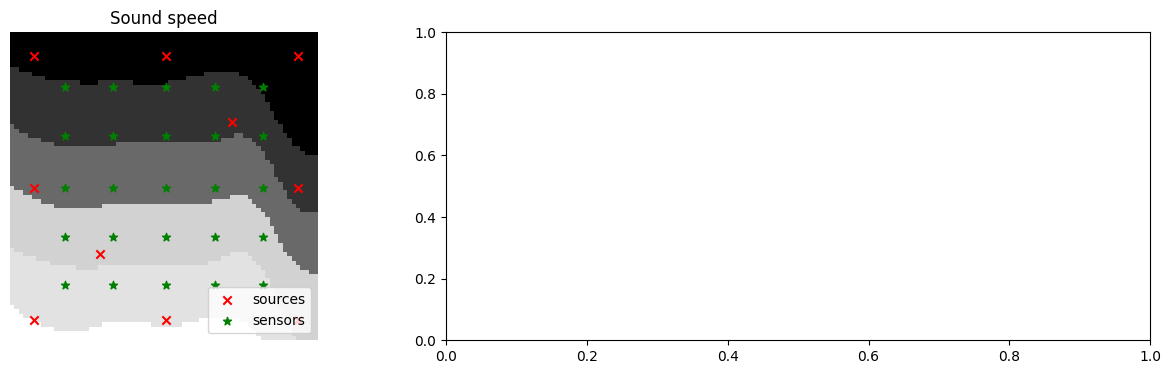

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 2]})

ax[0].imshow(true_model, cmap="gray")
ax[0].scatter(
    source_positions[1], source_positions[0], c="r", marker="x", label="sources"
)
ax[0].scatter(
    sensors_positions[1], sensors_positions[0], c="g", marker="*", label="sensors"
)
ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

# ax[1].plot(signal, label="Source 1", c="k")
# ax[1].set_title("Source signals")
# ax[1].get_yaxis().set_visible(False)

(np.float64(-0.5), np.float64(69.5), np.float64(69.5), np.float64(-0.5))

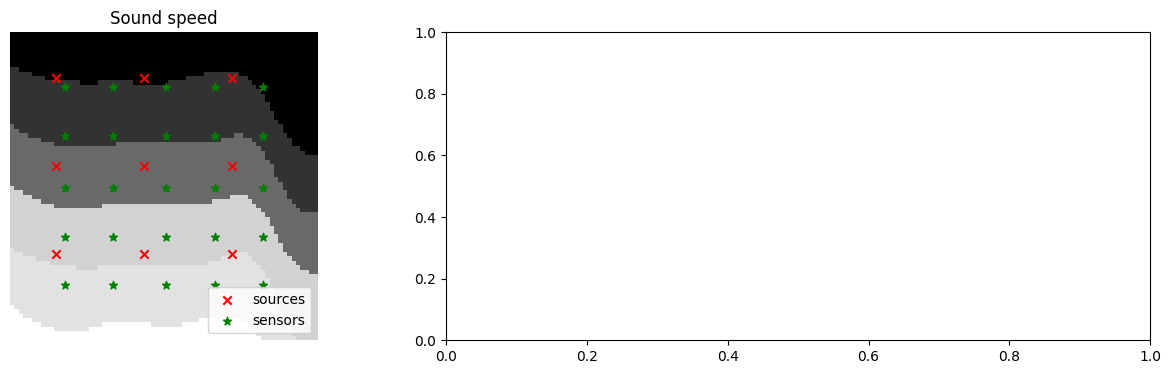

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 2]})

ax[0].imshow(true_model, cmap="gray")
ax[0].scatter(
    ref_source_positions[1], ref_source_positions[0], c="r", marker="x", label="sources"
)
ax[0].scatter(
    sensors_positions[1], sensors_positions[0], c="g", marker="*", label="sensors"
)
ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

# ax[1].plot(signal, label="Source 1", c="k")
# ax[1].set_title("Source signals")
# ax[1].get_yaxis().set_visible(False)

In [7]:
f0 = 200
dx = dy = 0.8
dt_ben = 12e-5
# n_steps_forward = int(326 * 3.63)
n_steps_forward = int(326 * 0.8)

density = jnp.ones_like(true_model) * 1000.0
pml_width = 2

# transform the sensors positions to the the same format as the receiver_is
receiver_is_modif = jnp.stack([sensors_positions[0], sensors_positions[1]], axis=-1)
source_modif = jnp.stack([source_positions[0], source_positions[1]], axis=-1)
num_sources = source_modif.shape[0]


ref_source_positions_modif = jnp.stack([ref_source_positions[0], ref_source_positions[1]], axis=-1)

# make the y coordinate 70 - y coordinate (seond value of the tuple)
# receiver_is_modif = jnp.stack([receiver_is_modif[:,0], 70 - receiver_is_modif[:,1]], axis=-1)
# source_modif = jnp.stack([source_modif[:,0], 70 - source_modif[:,1]], axis=-1)
# print(source_modif,receiver_is_modif)


# Use vmap to simulate wave propagation for all sources
# simulate_for_source = lambda source_i: acoustic2D(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps, receiver_is_modif)
# simulate_for_source = lambda source_i: acoustic2D_pml_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps, receiver_is_modif, pml_width=pml_width)
# simulate_for_source = lambda source_i: acoustic2D_pml_4th_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps, receiver_is_modif, pml_width=10)
# p_data_true, wavefields = vmap(simulate_for_source)(source_modif)

model = homogenous_model

p_test_pml, wavefields_test_pml = acoustic2D_pml_minmem(model, density, source_modif[3], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)
p_test_ref_pml, wavefields_test_ref_pml = acoustic2D_pml_minmem(model, density, ref_source_positions_modif[1], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)


p_test_cpml, wavefields_test_cpml = acoustic2D_cpml_minmem(model, density, source_modif[3], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)
p_test_ref_cpml, wavefields_test_ref_cpml = acoustic2D_cpml_minmem(model, density, ref_source_positions_modif[1], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)

p_test_cpml_stripped, wavefields_test_cpml_strip = acoustic2D_cpml_minmem_strips_diff(model, density, source_modif[3], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)
p_test_ref_cpml_strip, wavefields_test_ref_cpml_strip = acoustic2D_cpml_minmem_strips_diff(model, density, ref_source_positions_modif[1], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)

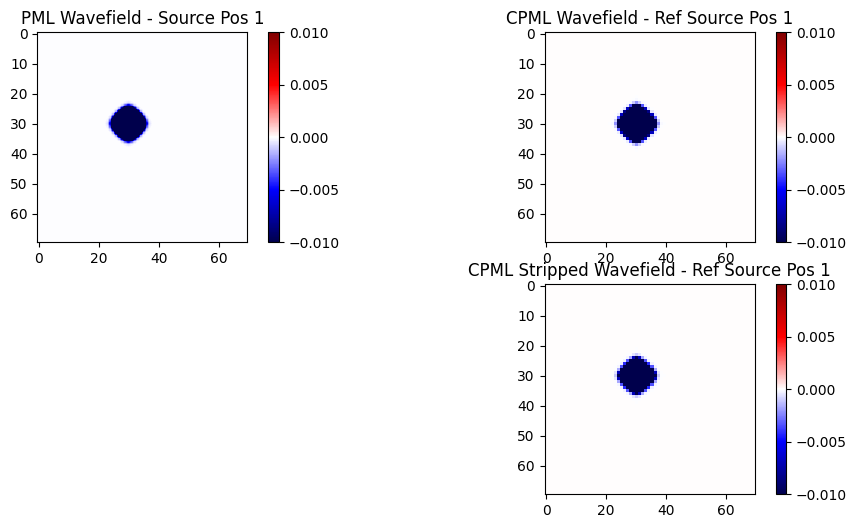

In [8]:
# make a plot wit the wavefileds of the first source for pml and cpml
time_step_index = 10
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(wavefields_test_ref_pml[time_step_index, :, :], cmap='seismic', vmin=-0.01, vmax=0.01)
plt.title('PML Wavefield - Source Pos 1')
plt.colorbar()
plt.subplot(2, 2, 2)
plt.imshow(wavefields_test_ref_cpml[time_step_index, :, :], cmap='seismic', vmin=-0.01, vmax=0.01)
plt.title('CPML Wavefield - Ref Source Pos 1')
plt.colorbar()
plt.subplot(2, 2, 4)
plt.imshow(wavefields_test_ref_cpml_strip[time_step_index, :, :], cmap='seismic', vmin=-0.01, vmax=0.01)
plt.title('CPML Stripped Wavefield - Ref Source Pos 1')
plt.colorbar()


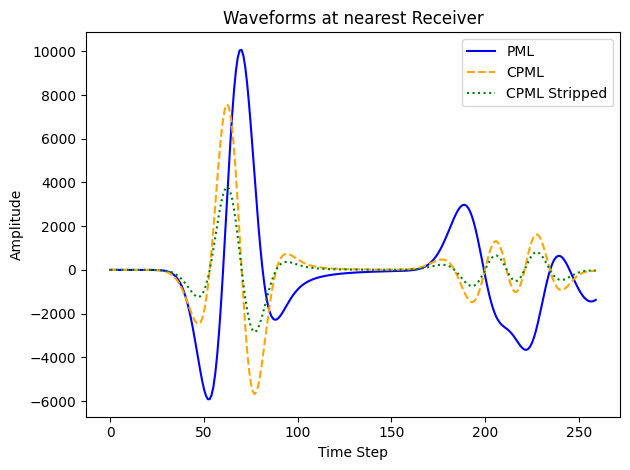

In [9]:
# plot the waveforms 
plt.plot(p_test_ref_pml[:, 12], label='PML', color='blue')
plt.plot(p_test_ref_cpml[:, 12], label='CPML', color='orange', linestyle='--')
plt.plot(p_test_ref_cpml_strip[:, 12], label='CPML Stripped', color='green', linestyle=':')
plt.title('Waveforms at nearest Receiver')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


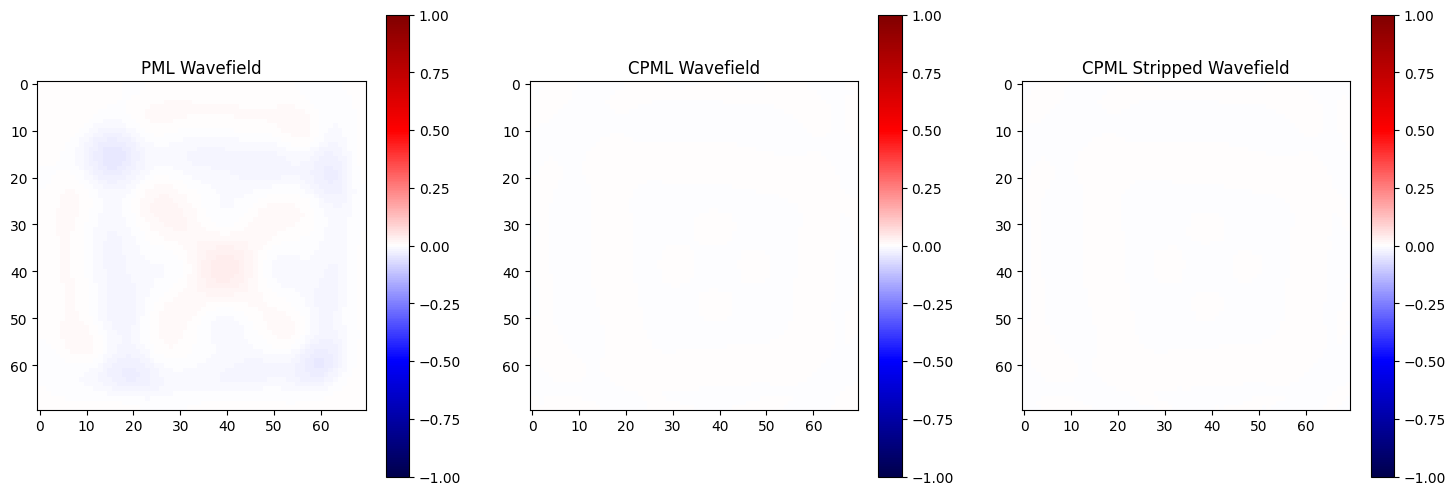

In [10]:
# make an animation of the wavefield propagation, the time stepping is the first axis for pml and cpml. save the anim in a gif
import matplotlib.animation as animation

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
im1 = ax[0].imshow(wavefields_test_ref_pml[0, :, :]/wavefields_test_ref_pml.max(), cmap='seismic', vmin=-1, vmax=1)
ax[0].set_title('PML Wavefield')
fig.colorbar(im1, ax=ax[0])
im2 = ax[1].imshow(wavefields_test_ref_cpml[0, :, :]/wavefields_test_ref_cpml.max(), cmap='seismic', vmin=-1, vmax=1)
ax[1].set_title('CPML Wavefield')
fig.colorbar(im2, ax=ax[1])
im3 = ax[2].imshow(wavefields_test_ref_cpml_strip[0, :, :]/wavefields_test_ref_cpml_strip.max(), cmap='seismic', vmin=-1, vmax=1)
ax[2].set_title('CPML Stripped Wavefield')
fig.colorbar(im3, ax=ax[2])

def update(frame):
    im1.set_array(wavefields_test_ref_pml[frame, :, :]/wavefields_test_ref_pml.max())
    im2.set_array(wavefields_test_ref_cpml[frame, :, :]/wavefields_test_ref_cpml.max())
    im3.set_array(wavefields_test_ref_cpml_strip[frame, :, :]/wavefields_test_ref_cpml_strip.max())
    return im1, im2, im3

ani = animation.FuncAnimation(fig, update, frames=wavefields_test_ref_pml.shape[0], blit=True)

ani.save('wavefield_propagation_homo.gif', writer='imagemagick')

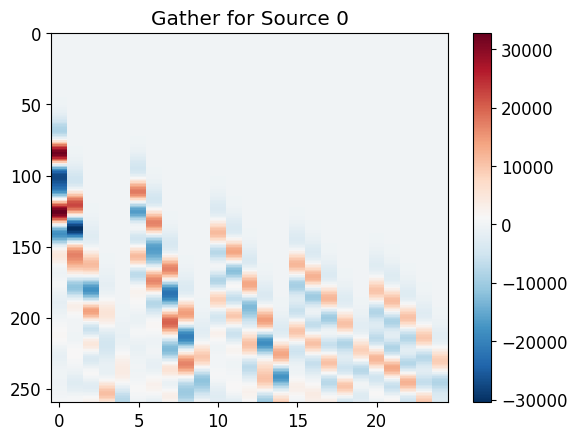

(260, 25)


In [49]:
# plot the gather for the first source
# minimum = np.amin(p_data_true[12])
plt.imshow((p_test), cmap="RdBu_r", interpolation="nearest", aspect="auto")
plt.colorbar()
plt.title('Gather for Source 0')
plt.show()
print(p_test.shape)

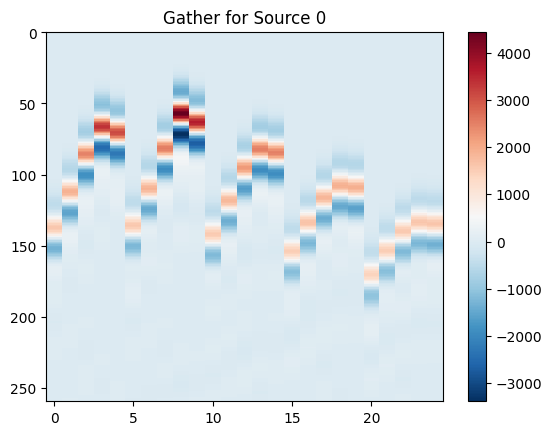

In [11]:
# plot the gather for the first source
# minimum = np.amin(p_data_true[12])
plt.imshow((p_test_cpml_stripped), cmap="RdBu_r", interpolation="nearest", aspect="auto")
plt.colorbar()
plt.title('Gather for Source 0')
plt.show()
# print(p_test_ref.shape)

In [10]:
fcn_params = {
    "criterion_threshold": 1e-10,
    "regularisation_loss": 0.0,
    "norm_loss": 0.0,
    "top_k_loss": 0.0,
    "differentiable_mask_sharpness": 10.0,
    "number_of_k":10,
    "hidden_size": 56,
    "num_hidden_layers": 3,
    "learning_rate": 2e-2,
    "num_iterations": 15,
    "print_gradients": False,
    "num_sources": num_sources,
}

In [11]:
# Differentiable Mask
def differentiable_mask(probabilities, sharpness=10.0):
    return jax.nn.sigmoid(sharpness * (probabilities - 0.5))

# def top_k_regularization(soft_mask, k=10):
#     top_k_values = jax.lax.top_k(soft_mask, k)[0]
#     penalty = jnp.sum(soft_mask) - jnp.sum(top_k_values)
#     return penalty

def smooth_fun(gradient):
    # x = gradient.on_grid[..., 0]
    x = gradient
    for _ in range(1):
        x = smooth(x)
    return x
@jit
def fwi(src_position):
    print("source position in fwi", src_position)
    num_steps_fwi = 150 # for pml implementation
    # num_steps_fwi = 80 # for cpml implementation
    key = random.PRNGKey(42)
    _, key = random.split(key)
    # initial model is the blurred model
    # params_fwi = blurred_model

    def simulate_true(src):
        p_rec, _ = acoustic2D_pml_minmem(
            true_model, density, src,
            f0, dx, dy, dt_ben, n_steps_forward,
            receiver_is_modif, pml_width=pml_width, output_wavefield=True
        )
        return p_rec

    p_data_obs = vmap(simulate_true)(src_position)  # [Nsrc, Nt, Nrec] is equivalent to making a measurements of the True model with the initial position once every start of the FWI loop

    init_fun_fwi, update_fun_fwi, get_params_fwi = optimizers.adam(25.0, 0.9, 0.9)
    opt_state_fwi = init_fun_fwi(blurred_model)
    # opt_state_fwi = init_fun_fwi(homogenous_model)

    # print(f"Size of data [Source idx, Time, Sensor idx]: {p_data.shape}")

    def loss_func_fwi(opt_state_fwi, src_num):
        @jit
        def simulate_one(src_num):
            p_rec, _ = acoustic2D_pml_minmem(
                opt_state_fwi, density, src_position[src_num],
                f0, dx, dy, dt_ben, n_steps_forward,
                receiver_is_modif, pml_width=pml_width, output_wavefield=True
            )
            return p_rec
        
        # simulate_all = jit(vmap(simulate_one))
        # p_pred = simulate_all(src_position)
        # p_pred,_ = acoustic2D_pml_minmem(params_fwi, density, src_position[src_num], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)
        p_pred = simulate_one(src_num)

        data = p_data_obs[src_num]

        print(p_pred.shape, data.shape)
        return jnp.mean((p_pred - data) ** 2)

    loss_with_grad_fwi = value_and_grad(loss_func_fwi,argnums=0)

    # Define and compile the update function
    @jit
    def update_fwi(opt_state, key, k):
        v = get_params_fwi(opt_state)
        src_num = random.choice(key, num_sources)
        lossval, gradient = loss_with_grad_fwi(v, src_num)
        gradient = smooth_fun(gradient)
        # gradient *= probabilities[src_num]
        return lossval, update_fun_fwi(k, gradient, opt_state)

    @jit
    def body(carry, k):
        opt_state, key = carry
        _, key = random.split(key)      # throw away first, keep second
        lossval, opt_state = update_fwi(opt_state, key, k)
        return (opt_state, key), lossval

    (opt_state_fwi, _), losses = lax.scan(body, (opt_state_fwi, key), jnp.arange(num_steps_fwi))
    new_params = get_params_fwi(opt_state_fwi)

    return new_params


nx, ny = true_model.shape

# we’ll clamp i ∈ [pml, nx-1-pml], j ∈ [pml, ny-1-pml]
@jit
def clamp_sources(src):
    i_clamped = jnp.clip(src[:,0], pml_width, nx - 1 - pml_width)
    j_clamped = jnp.clip(src[:,1], pml_width, ny - 1 - pml_width)
    return jnp.stack([i_clamped, j_clamped], axis=-1)

In [12]:
simulate_for_source = lambda source_i: acoustic2D_pml_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width, output_wavefield=True)
#     # simulate_for_source = lambda source_i: acoustic2D_pml_4th_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps, receiver_is_modif, pml_width=10)
p_data_true, _ = vmap(simulate_for_source)(source_modif)
print(len(p_data_true))

10


source position in fwi Traced<ShapedArray(float32[10,2])>with<DynamicJaxprTrace(level=1/0)>
(260, 25) (260, 25)


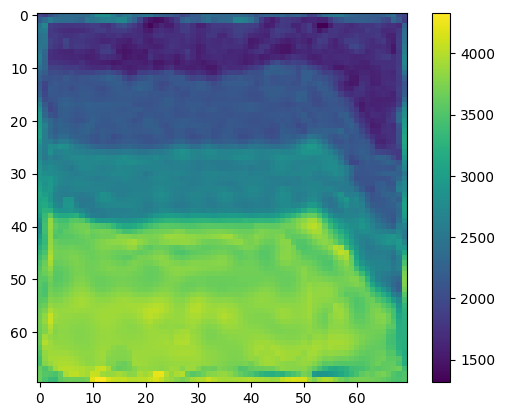

47412.25


In [13]:
iin = fwi(source_modif)
plt.imshow(iin)
plt.colorbar()
plt.show()
# L1 loss
print(jnp.linalg.norm((iin - jnp.fliplr(true_model)), ord=1))

source position in fwi Traced<ShapedArray(float32[9,2])>with<DynamicJaxprTrace(level=1/0)>
(260, 25) (260, 25)


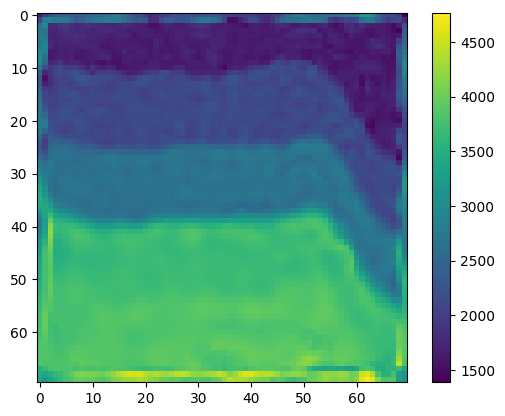

50954.35


In [14]:
iin = fwi(ref_source_positions_modif)
plt.imshow(iin)
plt.colorbar()
plt.show()
# L1 loss
print(jnp.linalg.norm((iin - jnp.fliplr(true_model)), ord=1))

In [15]:
# Differentiable Loss Function for the optimizer
def outer_loss(args):
    # probabilities = model(x)  # Predict probabilities
    # soft_mask = differentiable_mask(probabilities, sharpness)  # Generate soft mask
    
    

    # multiplier = matrix.shape[0] // soft_mask.shape[0]
    # soft_mask = jnp.repeat(soft_mask, multiplier, axis=0)

    # weighted_matrix = soft_mask[:, None] * matrix  # Apply mask to matrix rows

    # regularization_loss = mask_penalty * jnp.mean(soft_mask * (1 - soft_mask))  # Encourage binary mask
    # norm_loss = jnp.linalg.norm(soft_mask, ord=1)
    # top_k_loss = top_k_regularization(soft_mask, k=fcn_params["number_of_k"])

    # singular_loss = eigenvalue_criterion(weighted_matrix, threshold=criterion_threshold)
    inverted_model = fwi(args)
    def simulate_rec(src):
        p_rec, _ = acoustic2D_pml_minmem(
            inverted_model, density, src,
            f0, dx, dy, dt_ben, n_steps_forward,
            receiver_is_modif, pml_width=pml_width, output_wavefield=True
        )
        return p_rec

    p_pred = vmap(simulate_rec)(ref_source_positions_modif)
    simulate_for_source_actual_model = lambda source_i: acoustic2D_pml_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width, output_wavefield=True)
    ref_data, _ = vmap(simulate_for_source_actual_model)(ref_source_positions_modif)

    # fwi_loss = jnp.linalg.norm((inverted_model - true_model), ord=1)
    # fwi_loss = jnp.mean((inverted_model - true_model) ** 2)
    data_loss = jnp.mean((p_pred - ref_data) ** 2)

    # fwi_loss = lossval

    # logs["models"].append(inverted_model)


    # return -(singular_loss) + params["regularisation_loss"]*regularization_loss + params["norm_loss"]*norm_loss + params["top_k_loss"]*top_k_loss
    # return fwi_loss #+ fcn_params["regularisation_loss"]*regularization_loss + fcn_params["norm_loss"]*norm_loss 
    return data_loss

# loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)



In [16]:
# @partial(jit, static_argnums=(1))
@jit
def outer_step(fargs, state):

    # Print gradients for debugging
    def print_grads(grads):
        print("Gradients in step function:")

        def print_leaf(x):
            if x is None:
                print("None")
            else:
                print(x)
        jax.tree_util.tree_map(print_leaf, grads)


    loss, grad_src = jax.value_and_grad(outer_loss)(fargs)
    updates, state = outer_optimiser.update(grad_src, state)
    fargs = optax.apply_updates(fargs, updates)

    fargs = clamp_sources(fargs)
    
    return fargs, state, loss

In [17]:
fargs = source_modif
outer_optimiser = optax.adam(learning_rate=2.0)
opt_state = outer_optimiser.init(eqx.filter(fargs, eqx.is_array))
n_steps_outer = 40


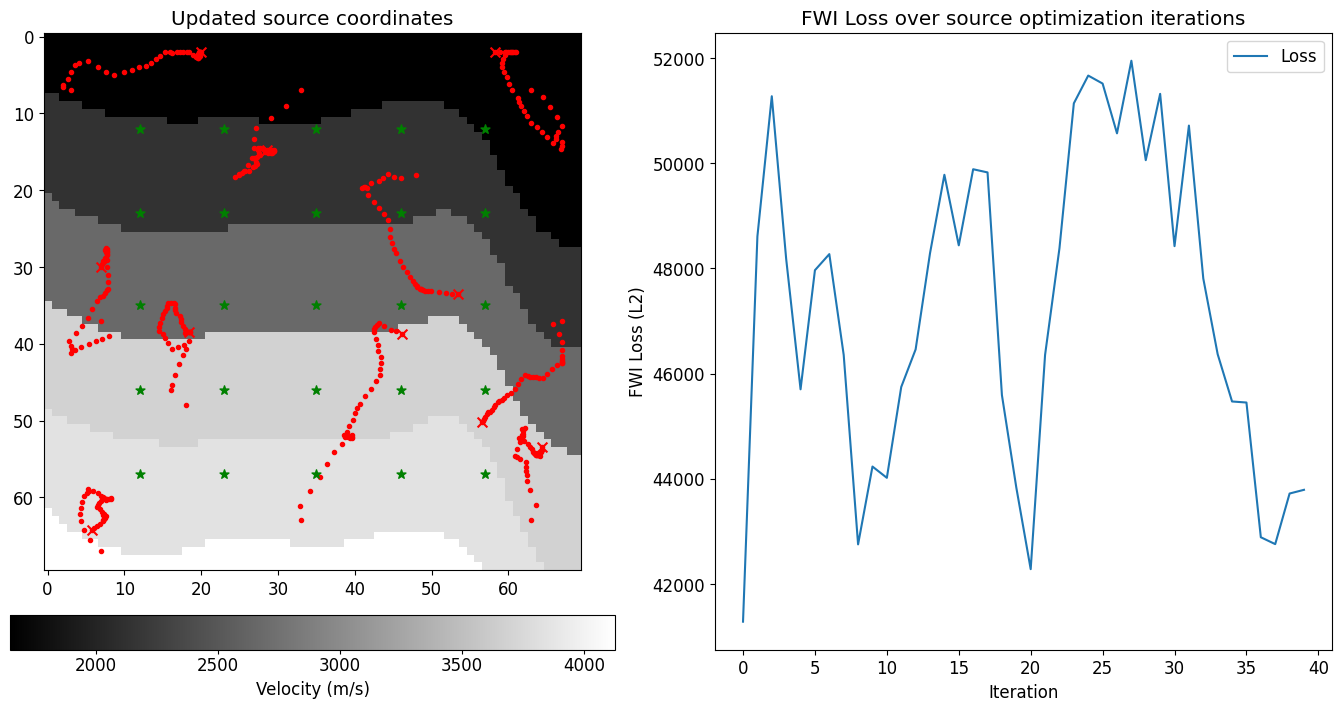

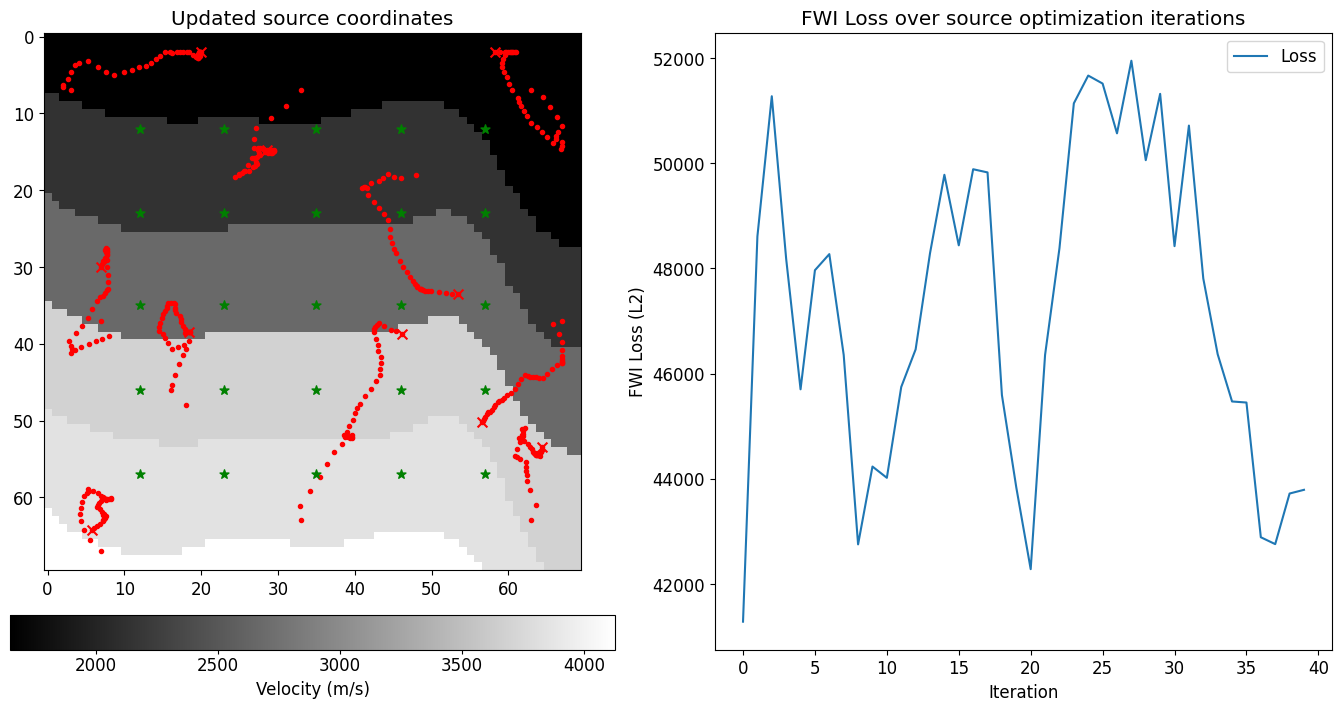

Final Loss: 21680.541


In [18]:
font_size = 12
plt.rcParams.update({'font.size': font_size})

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# --- Figure with horizontal colorbar under the LEFT plot ---
fig = plt.figure(figsize=(14, 7), layout="constrained")
axs = fig.subplot_mosaic(
    [["left", "right"],
     ["cbar", "right"]],
    width_ratios=[0.8, 1],
    height_ratios=[1, 0.065],   # adjust (e.g., 0.08–0.12) if you want a thinner/thicker cbar
)

ax1  = axs["left"]
ax2  = axs["right"]
cax  = axs["cbar"]   # dedicated axes for the horizontal colorbar under the left plot

# Make LEFT and RIGHT plots square (axes box, not data ratio)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

# Base image (fixed) + single, persistent colorbar (horizontal, under left)
im   = ax1.imshow(true_model, cmap="gray", interpolation="nearest", aspect="equal")
cbar = fig.colorbar(im, cax=cax, orientation="horizontal", label="Velocity (m/s)")
cbar.ax.tick_params(length=3, pad=2)
ax1.set_title("Updated source coordinates")

# Persistent loss line
(line_loss,) = ax2.plot([], [], label="Loss")
ax2.set_title("FWI Loss over source optimization iterations")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("FWI Loss (L2)")
ax2.legend()

lossvals = []
fwi_loss_vals = []
source_trajectories = []
receiver_trajectories = []

def clear_overlays(ax):
    for ln in ax.lines[:]:
        ln.remove()
    for coll in ax.collections[:]:
        coll.remove()
    for p in ax.patches[:]:
        p.remove()

for i in range(n_steps_outer):
    tic = time.time()
    fargs, opt_state, lossval = outer_step(fargs, opt_state)
    lossvals.append(lossval)
    print(f"Step {i}, Loss: {lossval}, Time: {time.time() - tic:.3f}s")

    inverted_model = fwi(fargs)
    fwi_loss = jnp.mean((inverted_model - true_model) ** 2)
    fwi_loss_vals.append(fwi_loss)


    source_trajectories.append(fargs)
    receiver_trajectories.append(receiver_is_modif)

    # Update overlays on the left (image & colorbar persist)
    clear_overlays(ax1)
    for traj in source_trajectories:
        ax1.scatter(*traj.T[::-1], s=35, marker='.', color='r')
    for rec in receiver_is_modif:
        ax1.scatter(*rec.T[::-1], s=45, marker='*', color='g')
    for src in fargs:
        ax1.scatter(*src.T[::-1], s=50, marker='x', color='r')

    # Update loss line (axes stays square due to box aspect)
    x = np.arange(len(lossvals))
    # line_loss.set_data(x, lossvals)
    line_loss.set_data(x,fwi_loss_vals)
    ax2.relim()
    ax2.autoscale_view()

    clear_output(wait=True)
    display(fig)
    fig.canvas.draw_idle()
    fig.savefig(f"opti_movie/step_{i}.png")  # keep default bbox to preserve layout

plt.show()
print("Final Loss:", lossvals[-1])

# Save results
np.save('source_trajectories.npy', np.array(source_trajectories, dtype=object))
np.save('receiver_trajectories.npy', np.array(receiver_trajectories, dtype=object))
np.save('lossvals.npy', np.array(lossvals))

In [19]:
final_model = fwi(fargs)
initial_model = fwi(source_modif)

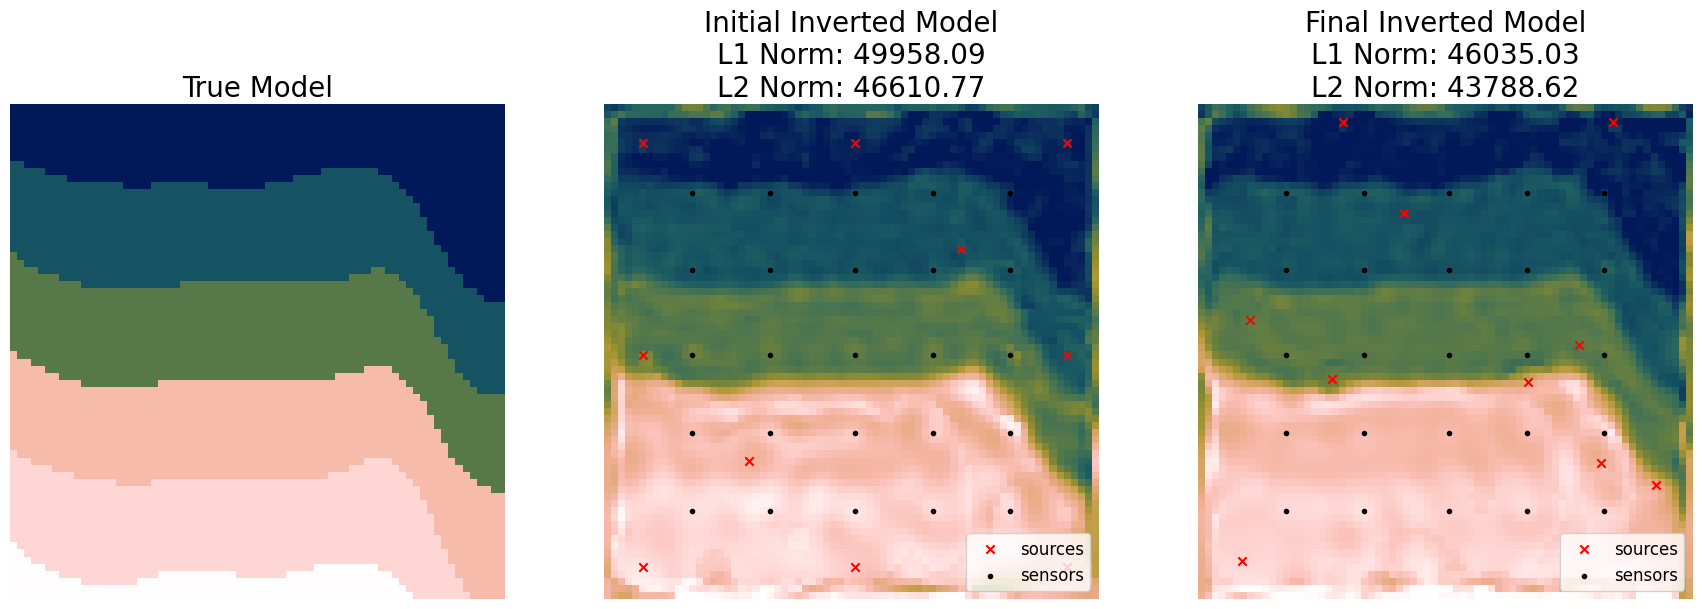

In [20]:

vmin, vmax = true_model.min(), true_model.max()

l1_norm_initial = jnp.linalg.norm((initial_model - true_model), ord=1)
l1_norm_final = jnp.linalg.norm((final_model - true_model), ord=1)

# l2_norm_initial = jnp.linalg.norm((initial_model - true_model), ord=2)
# l2_norm_final = jnp.linalg.norm((final_model - true_model), ord=2)

l2_norm_initial = (jnp.mean((initial_model - true_model) ** 2))
l2_norm_final = (jnp.mean((final_model - true_model) ** 2))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the true model
im = axes[0].imshow(true_model, cmap=cm.batlowW, vmin=vmin, vmax=vmax)
axes[0].set_title('True Model', fontsize=20)
axes[0].axis('off')
# fig.colorbar(im, ax=axes[0], orientation='vertical')

# Plot the initial inverted model
im = axes[1].imshow(initial_model, cmap=cm.batlowW, vmin=vmin, vmax=vmax)
axes[1].scatter(source_positions[1], source_positions[0], c="r", marker="x", label="sources")
axes[1].scatter(sensors_positions[1], sensors_positions[0], c="k", marker=".", label="sensors")
axes[1].set_title(f'Initial Inverted Model\nL1 Norm: {l1_norm_initial:.2f}\nL2 Norm: {l2_norm_initial:.2f}', fontsize=20)
axes[1].axis('off')
axes[1].legend(loc="lower right")
# fig.colorbar(im, ax=axes[1], orientation='vertical')

# Plot the final inverted model
im = axes[2].imshow(final_model, cmap=cm.batlowW, vmin=vmin, vmax=vmax)
axes[2].scatter(fargs[:,1], fargs[:,0], c="r", marker="x", label="sources")
axes[2].scatter(sensors_positions[1], sensors_positions[0], c="k", marker=".", label="sensors")
axes[2].set_title(f'Final Inverted Model\nL1 Norm: {l1_norm_final:.2f}\nL2 Norm: {l2_norm_final:.2f}', fontsize=20)
axes[2].axis('off')
axes[2].legend(loc="lower right")
# fig.colorbar(im, ax=axes[2], orientation='vertical')

plt.tight_layout()
# plt.show()


(260, 25)


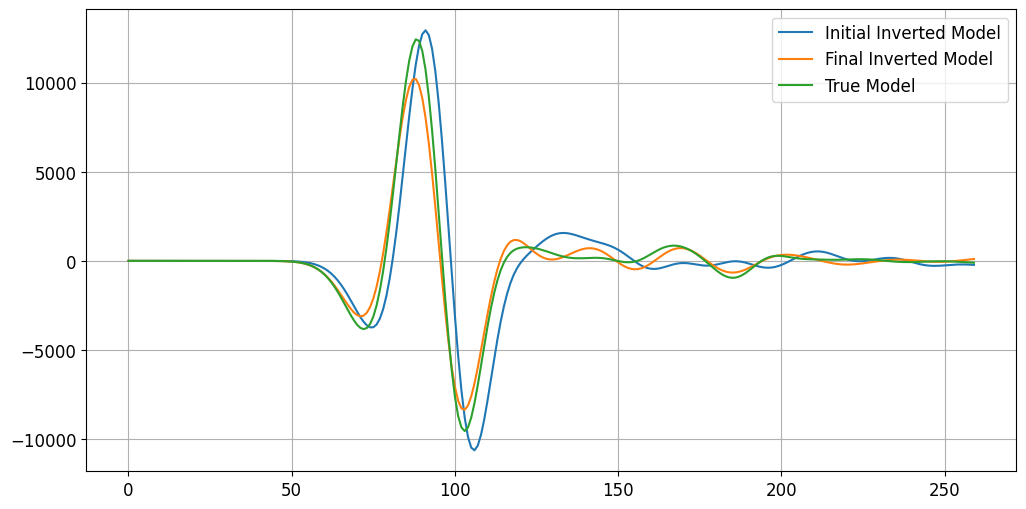

In [22]:
# Look at the initial, final  layout traces and true model traces
source_idx = 0
trace_index = 5

p_true, wavefields_ini = acoustic2D_cpml_minmem(true_model, density, ref_source_positions_modif[source_idx], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)

p_ini, wavefields_ini = acoustic2D_cpml_minmem(initial_model, density, ref_source_positions_modif[source_idx], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)

p_final, wavefields_final = acoustic2D_cpml_minmem(final_model, density, ref_source_positions_modif[source_idx], f0, dx, dy, dt_ben, n_steps_forward, receiver_is_modif, pml_width=pml_width)



print(p_ini.shape)

# plot a few traces
plt.figure(figsize=(12, 6))
plt.plot(p_ini[ :, trace_index], label='Initial Inverted Model')
plt.plot(p_final[ :, trace_index], label='Final Inverted Model')
plt.plot(p_true[ :, trace_index], label='True Model')
plt.grid()
plt.legend()
plt.show()


In [22]:
print(fargs)

[[16.38444   13.950541 ]
 [ 2.        59.450993 ]
 [26.254986  53.824955 ]
 [10.937537  38.512135 ]
 [ 9.709988   2.       ]
 [28.69385   47.37943  ]
 [45.797436   7.1048193]
 [62.569813  16.945185 ]
 [58.80939   46.854218 ]
 [58.99601   47.43238  ]]


In [ ]:
# write the fargs to a numpy file for easy reading
# np.save('optimized_source_positions_testcaseBD_dataloss.npy', np.array(fargs))


In [24]:
# can you generate a movie of the pictures of the optimization steps?
import imageio
import glob
import re
images = []
# Ensure images are loaded in numerical order

def extract_step_number(fname):
    match = re.search(r"step_(\d+)\.png", fname)
    return int(match.group(1)) if match else -1

file_list = sorted(glob.glob("opti_movie/step_*.png"), key=extract_step_number)
for filename in file_list:
    images.append(imageio.imread(filename))
imageio.mimsave('optimization_steps.gif', images, fps=2)

/tmp/ipykernel_2464770/1149313097.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
